In [56]:
# Here we perform the obligatory worship of the long-forgotten masters. Long may they reign from on high. This is code 
# for, 'we import modals'.

# Magic!
%matplotlib inline

import os
import glob

import numpy as np
from matplotlib import pyplot as plt

from os.path import basename, dirname
from scipy.misc import imresize

from keras.utils import to_categorical

Download and extract the data archive from Canvas.  In what follows, we'll assume that the contents of that archive are contained in a local directory names `data`.

In [57]:
data_path = 'data/'

Within the `data` directory, images have been divided into training, validation, and test sets.  We can use `glob` to get a lift of paths to all of the images

In [58]:
train_dir = 'data/train/'
valid_dir = 'data/valid/'
test_dir = 'data/test/'

train_paths = glob.glob(train_dir+"/*.jpg")
valid_paths = glob.glob(valid_dir+"/*.jpg")
test_paths = glob.glob(test_dir+"/*.jpg")

Let's take a look at one of the training images.

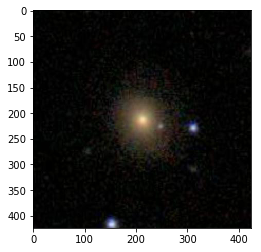

In [59]:
im = plt.imread(train_paths[0])
plt.imshow(im)

To cut down on size, let's zoom and and use a lower resolution.

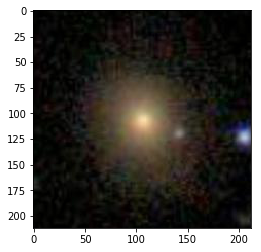

In [60]:
im = im[106:106*3, 106:106*3, :] #crop 424x424 -> 212x212
plt.imshow(im)

We'll define some convenience functions to do this on a larger scale, and extract labels from the `CSV` file.

In [61]:
def process_images(paths):
    """
    Import images at `paths`, decode, center and crop 
    """
    count = len(paths)
    arr = np.zeros(shape=(count, 106, 106, 3))
    for c, path in enumerate(paths):
        img = plt.imread(path)
        img = img[106:106*3,106:106*3, :] #crop 424x424 -> 212x212
        img = imresize(img, size=(106, 106), interp="cubic") # downsample to half res
        arr[c] = img/255.
    return arr


def process_labels(training_img_paths, training_results_path='data/training_solutions_rev1.csv'):
    """
    Based on image paths, read the relevant IDs from the CSV file and return labels in one-hot
    """
    results = np.loadtxt(training_results_path, delimiter=',', skiprows=1)
    result_ids = results[:, 0].astype(int)
    
    labels = np.zeros((len(training_img_paths), results.shape[1]-1), dtype=int)
    for i, fname in enumerate(training_img_paths):
        id = int(basename(fname).strip('.jpg'))
        sel = result_ids == id
        labels[i, np.argmax(results[sel][0, 1:])] = 1
    return labels

For a cheap sanity check, try loading the first 10 training images.

In [62]:
training_imgs = process_images(train_paths[:10])
training_labels = process_labels(train_paths[:10])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [63]:
print(training_labels[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


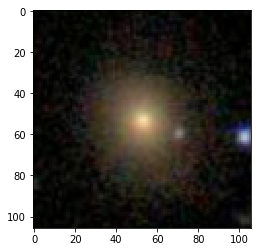

In [64]:
plt.imshow(training_imgs[0])

In [65]:
# Load compleat set of training data and training solutions using the definitions given.
training_imgs = process_images(train_paths)
training_labels = process_labels(train_paths)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [66]:
# Load validation data and solutions.
validation_imgs = process_images(valid_paths)
validation_labels = process_labels(valid_paths)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [67]:
# Use .shape to see the length of each data set, and cheack the resolution of the images.

print(len(training_labels))
print(len(training_imgs))

print(len(validation_labels))
print(len(validation_imgs))

training_imgs.shape,training_labels.shape,validation_imgs.shape,validation_labels.shape

5000
5000
1000
1000


((5000, 106, 106, 3), (5000, 37), (1000, 106, 106, 3), (1000, 37))

In [68]:
# Import keras functions that will be used in our models.
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

# Import classification_report to view individual catagorical accuracy.
from sklearn.metrics import classification_report

# Attempt 1 (Convalution + Dropout Layers)

In [69]:
# Here we will define some useful quantities for latter use. The two that will be most used are the epochs, which is 
# the number of thimes we will iterate of the entir training set, and the num_classes, which is the number of things a 
# galaxy can be classified as. Batch size is the number of nodes a layer will have, but since that changes so much, we
# will useuly classify that in the model.

batch_size = 64
epochs = 20
num_classes = 37

In this initial model, we will be using a very simmular format as our fassion model from the week 8 homework. This means that we will have three convolution layers, each with a batch size that will be double the last. In between each convolution, we will have a leakyReLU layer and a maxpooling layer, as well as increasingly large dropout layers. After this last set of layers, we will converte to a fully conected layer, and then finaly to our output layer, with the same number of nodes as the number of classes. For an idea of what each of these layers are doing, we were given some exelent graphics.

Convalution:
<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">

MaxPooling:
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg", width=500>

Droupout:

Dropout is simply droping some persentage of the total data from any given sample, to avoid overfitting.

LeakyReLU:

Leaky is a version of a Rectified Linear Unit. It allows a small gradient when the unit is not active: 

$f(x) = \alpha * x$ for x < 0

$f(x) = x$ for x >= 0

Fully Conected (Dence) Unit:
<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg",width=300>

In [70]:
# Constructe the Galaxy model. 

# First define the model as sequential.
Galaxy_model = Sequential()
# Add a 2D convalutional layer
# input: 106x106 images with 3 channels -> (106, 106, 3) tensors.
Galaxy_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
Galaxy_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
Galaxy_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
Galaxy_model.add(Dropout(0.25))
# Add a second convalutional layer, with 64 filters, rather then 32.
Galaxy_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Galaxy_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
Galaxy_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
Galaxy_model.add(Dropout(0.25))
# Add a third 2D convolutional layer with 128 filters.
Galaxy_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Galaxy_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
Galaxy_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
Galaxy_model.add(Dropout(0.4))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
Galaxy_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
Galaxy_model.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
Galaxy_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
Galaxy_model.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
Galaxy_model.add(Dense(num_classes, activation='softmax'))

In [71]:
# Here we show the summary of the model we have constructed. 
Galaxy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 106, 106, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 53, 53, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 27, 27, 64)        0         
__________

In [72]:
# We now compile our Galaxy model.
Galaxy_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [73]:
# Using this Galaxy model we will train our model. We will use 20 epochs.
Galaxy_train = Galaxy_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 448s 90ms/step - loss: 1.2340 - acc: 0.5688 - val_loss: 1.0999 - val_acc: 0.6110
Epoch 2/20
5000/5000 [==============================] - 365s 73ms/step - loss: 1.0073 - acc: 0.6016 - val_loss: 0.9687 - val_acc: 0.6250
Epoch 3/20
5000/5000 [==============================] - 336s 67ms/step - loss: 0.9349 - acc: 0.6200 - val_loss: 0.9315 - val_acc: 0.6240
Epoch 4/20
5000/5000 [==============================] - 346s 69ms/step - loss: 0.8889 - acc: 0.6410 - val_loss: 0.8377 - val_acc: 0.6600
Epoch 5/20
5000/5000 [==============================] - 339s 68ms/step - loss: 0.8667 - acc: 0.6530 - val_loss: 0.8347 - val_acc: 0.6760
Epoch 6/20
5000/5000 [==============================] - 352s 70ms/step - loss: 0.8404 - acc: 0.6602 - val_loss: 0.8118 - val_acc: 0.6640
Epoch 7/20
5000/5000 [==============================] - 344s 69ms/step - loss: 0.8198 - acc: 0.6676 - val_loss: 0.8206 - val_acc: 

In [74]:
# Load test data and solutions.
test_imgs = process_images(test_paths)
test_labels = process_labels(test_paths)

print(len(test_labels))
print(len(test_imgs))

test_imgs.shape,test_labels.shape

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1000
1000


((1000, 106, 106, 3), (1000, 37))

In [75]:
# Comute the test accuracy and loss using our constructed model.
test_eval = Galaxy_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 20s 20ms/step


In [76]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.2100833320617677
Test accuracy: 0.631


After 20 epochs, and using our constructed model to look at our test data, it is here that we finaly see the fruits of our effort. In this case though, we are a bit disapointed. Our models test accuracy is only 66.5%, wich is better much better then random choice, but not good enough that I would feel comfortable leaving galaxy clasification up to this algarithum. The loss of our test data is also large, at 1.19. Given that we want our loss function to be approching zero, this is not a good sign. This infortmation tells us that this model was a bit of a failure, but let us look at the history of our run, to see if we might be able to tell what happend.

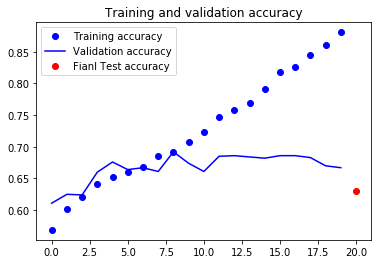

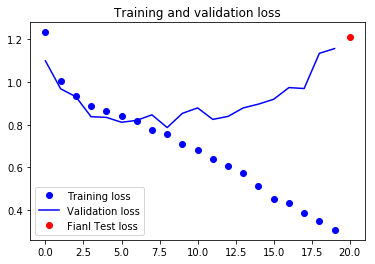

In [77]:
# We will plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = Galaxy_train.history['acc']
val_accuracy = Galaxy_train.history['val_acc']
loss = Galaxy_train.history['loss']
val_loss = Galaxy_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

By looking at the plot of our training and validation data, we see that we are in a classic case of overfitting. The training data improves in both accuracy and loss at a reasonable rate, but the validation data starts to platto at an accuracy of about 65-70%. At the point the loss also begins to increase. The most obviouse solution to solve this is to drasticly increase the amount of droupout in this system, but this could very well do more harm then good. We will have to look at a veriaty of different training models to try and find a workable solution that both avoids overfitting, and achives a high accuracy. In the meantime, let us look at the individual accuracies of each subclass in our model.

In [80]:
# Let us look at the individual precisions in our models training data.
print('Catagorical Training Accuracy')
Y_train = np.argmax(training_labels, axis=1) # Convert one-hot to index
y_pred = Galaxy_model.predict_classes(training_imgs) # Use predict_classes to make pridictions
target_names = ['Class 1.1','Class 1.2','Class 1.3','Class 6.1','Class 6.2']
print(classification_report(Y_train, y_pred, target_names=target_names)) # Print our data

Catagorical Training Accuracy
             precision    recall  f1-score   support

  Class 1.1       0.98      0.86      0.91       455
  Class 1.2       0.88      0.97      0.93      1265
  Class 1.3       1.00      1.00      1.00         1
  Class 6.1       0.95      0.97      0.96       283
  Class 6.2       0.97      0.94      0.96      2996

avg / total       0.95      0.94      0.94      5000



In [81]:
# Let us look at the individual precisions in our models training data.
print('Catagorical Training Accuracy')
Y_val = np.argmax(validation_labels, axis=1) # Convert one-hot to index
y_pred = Galaxy_model.predict_classes(validation_imgs) # Use predict_classes to make pridictions
target_names = ['Class 1.1','Class 1.2','Class 1.3','Class 6.1','Class 6.2']
print(classification_report(Y_val, y_pred, target_names=target_names)) # Print our data

Catagorical Training Accuracy
             precision    recall  f1-score   support

  Class 1.1       0.33      0.20      0.25        80
  Class 1.2       0.55      0.71      0.62       253
  Class 1.3       0.00      0.00      0.00         1
  Class 6.1       0.38      0.21      0.27        56
  Class 6.2       0.78      0.75      0.77       610

avg / total       0.66      0.67      0.66      1000



//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
print('Catagorical Test Accuracy')

# Let us look at the individual precisions in our models test data.

Y_test = np.argmax(test_labels, axis=1) # Convert one-hot to index
y_pred = Galaxy_model.predict_classes(test_imgs) # Use predict_classes to make pridictions
target_names = ['Class 1.1','Class 1.2','Class 6.1','Class 6.2']
print(classification_report(Y_test, y_pred, target_names=target_names)) # Print our data

Catagorical Test Accuracy
             precision    recall  f1-score   support

  Class 1.1       0.35      0.23      0.28        94
  Class 1.2       0.52      0.63      0.57       244
  Class 6.1       0.29      0.20      0.24        50
  Class 6.2       0.74      0.73      0.73       612

avg / total       0.62      0.63      0.62      1000



As expected, the accuracy of each sub group in the training set is much better then that found in the validation and test data. In fact, we can see that the galaxies marked as 1.1, 1.2 and 6.1 have accuracies below 50%. When we consider that there are accualy only five different catagories being modeled, this shows that this model is not doing a particularly effective job of catigorizing this data. It does alright with class 6.2 galexies and a little better then 50/50 with class 1.2 galexies, but given that the have by far the greatest number of enteries, this is not suprissing. Let us now look at some images that this model was able to classify, as well as some that it was not, and see if we can tell where it might be going wronge.

Found 597 correct labels


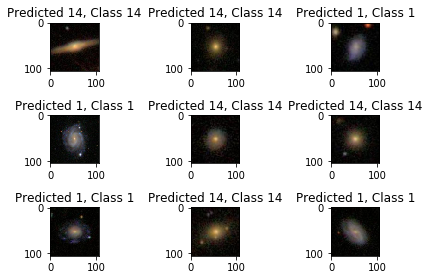

In [97]:
# Let us now only look at correct predictions. We can do this by only looking at where the predicted_classes array is
# equal to the test_Y array.
correct = np.where(predicted_classes==Y_test)[0]
# The number of correct predictions is the length of this correct array
print("Found %d correct labels" % len(correct))

for i, correct in enumerate(correct[:9]):
    # Creat 2 by 2 array of subplots, and set image to the i+1 position.
    plt.subplot(3,3,i+1)
    # plot particular image of a galexy
    plt.imshow(test_imgs[correct])
    # Set tital to the predicted class and the accural class.
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], Y_test[correct]))
    # Set a tight layout.
    plt.tight_layout()

Found 403 incorrect labels


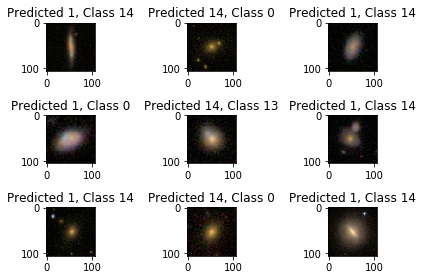

In [98]:
# Let us now only look at incorrect predictions. We can do this by only looking at where the predicted_classes array 
# is not equal to the test_Y array.
incorrect = np.where(predicted_classes!=Y_test)[0]
# The number of incorrect predictions is the length of this correct array
print("Found %d incorrect labels" % len(incorrect))

# Plot images of the first 9 incorrect predictions, along with the prediction and class listed above.
for i, incorrect in enumerate(incorrect[:9]):
    # Creat 3 by 3 array of subplots, and set image to the i+1 position.
    plt.subplot(3,3,i+1)
    # plot particular image of a galexy
    plt.imshow(test_imgs[incorrect])
    # Set tital to the predicted class and the accural class.
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Y_test[incorrect]))
    # Set tight layout
    plt.tight_layout()

As might have been predicted, it is difficult to tell why this program is missesifing some galexies. Since I do not know the classification system, it is difficult to disiffer. However, it is interesting to see what images this system is given to work with. While this model was only marginaly sucessful, it is still perfictly reasonable that a more correct model exsists. In order to try to find this model, I will try verious combinations and modifications to the model I have used here, as well as some others I found reference to online. With any luck, one will work well enough to consistently correctly classify our test data.

# Attempt 2 (Simplistic Model)

In [45]:
# Redifine these constents
batch_size = 64
epochs = 20
num_classes = 37

In [47]:
# Constructe the simple model

# First define the model as sequential.
simple_model = Sequential()
# Add a 2D convalutional layer
simple_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
simple_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
simple_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
simple_model.add(Dropout(0.25))

# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
simple_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
simple_model.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
simple_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
simple_model.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
simple_model.add(Dense(num_classes, activation='softmax'))

In [48]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
Galaxy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 106, 106, 32)      896       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 53, 53, 64)        18496     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 27, 27, 64)        0         
__________

In [49]:
# We now compile our Galaxy model.
simple_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [50]:
# Using this Galaxy model, with dropout layers, we will train our model. We will use 20 epochs.
simple_train = simple_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 247s 49ms/step - loss: 1.1563 - acc: 0.5868 - val_loss: 0.8936 - val_acc: 0.6320
Epoch 2/20
5000/5000 [==============================] - 217s 43ms/step - loss: 0.9282 - acc: 0.6230 - val_loss: 0.8609 - val_acc: 0.6630
Epoch 3/20
5000/5000 [==============================] - 192s 38ms/step - loss: 0.8360 - acc: 0.6644 - val_loss: 0.8659 - val_acc: 0.6580
Epoch 4/20
5000/5000 [==============================] - 163s 33ms/step - loss: 0.7828 - acc: 0.6918 - val_loss: 0.8440 - val_acc: 0.6820
Epoch 5/20
5000/5000 [==============================] - 186s 37ms/step - loss: 0.6879 - acc: 0.7306 - val_loss: 0.8169 - val_acc: 0.6820
Epoch 6/20
5000/5000 [==============================] - 197s 39ms/step - loss: 0.5883 - acc: 0.7684 - val_loss: 0.8502 - val_acc: 0.6720
Epoch 7/20
5000/5000 [==============================] - 203s 41ms/step - loss: 0.4764 - acc: 0.8176 - val_loss: 0.9363 - val_acc: 

In [51]:
# Comute the test accuracy and loss using our constructed model.
test_eval = simple_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 14s 14ms/step


In [52]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.7378624830245972
Test accuracy: 0.6


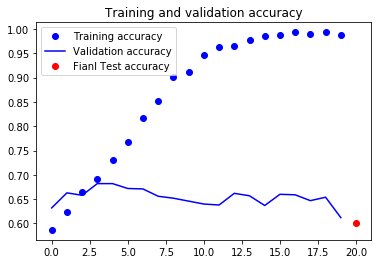

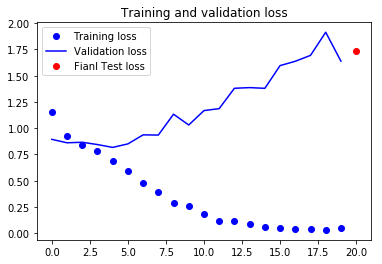

In [53]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = simple_train.history['acc']
val_accuracy = simple_train.history['val_acc']
loss = simple_train.history['loss']
val_loss = simple_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

While significalntly faster, this model had even more trouble with overfitting.

# Attempt 3 (More Dropout)

In [16]:
# Redefine Constents

batch_size = 64
epochs = 20
num_classes = 37

In [17]:
# Constructe the dropout model

# First define the model as sequential.
dropout_model = Sequential()
# Add a 2D convalutional layer
dropout_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
dropout_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
dropout_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
dropout_model.add(Dropout(0.3))
# Add a second convalutional layer, with 64 filters, rather then 32.
dropout_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
dropout_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
dropout_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
dropout_model.add(Dropout(0.35))
# Add a third 2D convolutional layer with 128 filters.
dropout_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
dropout_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
dropout_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
dropout_model.add(Dropout(0.45))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
dropout_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
dropout_model.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
dropout_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
dropout_model.add(Dropout(0.35))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
dropout_model.add(Dense(num_classes, activation='softmax'))

In [18]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 106, 106, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
__________

In [19]:
# We now compile our Galaxy model.
dropout_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [20]:
# Using this Galaxy model, with dropout layers, we will train our model. We will use 20 epochs.
dropout_train = dropout_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 373s 75ms/step - loss: 1.1806 - acc: 0.5678 - val_loss: 1.1256 - val_acc: 0.6350
Epoch 2/20
5000/5000 [==============================] - 344s 69ms/step - loss: 0.9946 - acc: 0.6082 - val_loss: 0.9033 - val_acc: 0.6260
Epoch 3/20
5000/5000 [==============================] - 321s 64ms/step - loss: 0.9420 - acc: 0.6212 - val_loss: 0.8972 - val_acc: 0.6410
Epoch 4/20
5000/5000 [==============================] - 317s 63ms/step - loss: 0.9014 - acc: 0.6378 - val_loss: 0.8450 - val_acc: 0.6660
Epoch 5/20
5000/5000 [==============================] - 314s 63ms/step - loss: 0.8730 - acc: 0.6468 - val_loss: 0.8434 - val_acc: 0.6590
Epoch 6/20
5000/5000 [==============================] - 401s 80ms/step - loss: 0.8714 - acc: 0.6468 - val_loss: 0.8298 - val_acc: 0.6700
Epoch 7/20
5000/5000 [==============================] - 381s 76ms/step - loss: 0.8547 - acc: 0.6480 - val_loss: 0.8765 - val_acc: 

In [21]:
# Comute the test accuracy and loss using our constructed model.
test_eval = dropout_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 18s 18ms/step


In [22]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1869685325622559
Test accuracy: 0.652


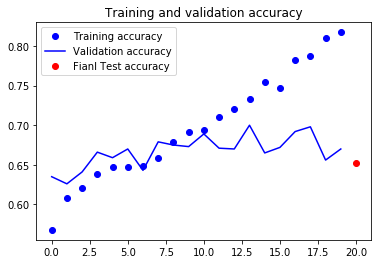

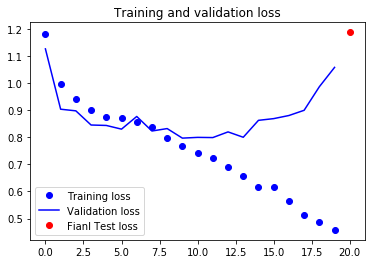

In [23]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = dropout_train.history['acc']
val_accuracy = dropout_train.history['val_acc']
loss = dropout_train.history['loss']
val_loss = dropout_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We see that by adding more dropout, we slightly decrease the amount of overfitting that is occuring, but it does not seem to have solved the issue.

# Attempt 4 (More Convalution Layers)

In [24]:
# Redefine Constents

batch_size = 64
epochs = 20
num_classes = 37

In [26]:
# Constructe the Complex model

# First define the model as sequential.
Complex_model = Sequential()
# Add a 2D convalutional layer
Complex_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
Complex_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
Complex_model.add(Dropout(0.25))
# Add a second convalutional layer, with 64 filters, rather then 32.
Complex_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
Complex_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
Complex_model.add(Dropout(0.25))
# Add a third 2D convolutional layer with 128 filters.
Complex_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
Complex_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
Complex_model.add(Dropout(0.4))

# Add a fourth 2D convolutional layer with 128 filters.
Complex_model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
Complex_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
Complex_model.add(Dropout(0.4))
# Add a fifth 2D convolutional layer with 128 filters.
Complex_model.add(Conv2D(512, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
Complex_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
Complex_model.add(Dropout(0.45))
# Add a sixth 2D convolutional layer with 128 filters.
Complex_model.add(Conv2D(1024, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
Complex_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
Complex_model.add(Dropout(0.45))



# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
Complex_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
Complex_model.add(Dense(1024, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
Complex_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
Complex_model.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
Complex_model.add(Dense(num_classes, activation='softmax'))

In [27]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
Complex_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 106, 106, 32)      896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 64)        0         
__________

In [28]:
# We now compile our Galaxy model.
Complex_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [29]:
# Using this Galaxy model, with dropout layers, we will train our model. We will use 20 epochs.
Complex_train = Complex_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 616s 123ms/step - loss: 6.4169 - acc: 0.5920 - val_loss: 6.2861 - val_acc: 0.6100
Epoch 2/20
5000/5000 [==============================] - 613s 123ms/step - loss: 6.4601 - acc: 0.5992 - val_loss: 6.2861 - val_acc: 0.6100
Epoch 3/20
5000/5000 [==============================] - 661s 132ms/step - loss: 6.4601 - acc: 0.5992 - val_loss: 6.2861 - val_acc: 0.6100
Epoch 4/20
5000/5000 [==============================] - 625s 125ms/step - loss: 6.4601 - acc: 0.5992 - val_loss: 6.2861 - val_acc: 0.6100
Epoch 5/20
5000/5000 [==============================] - 605s 121ms/step - loss: 6.4601 - acc: 0.5992 - val_loss: 6.2861 - val_acc: 0.6100
Epoch 6/20
5000/5000 [==============================] - 607s 121ms/step - loss: 6.4601 - acc: 0.5992 - val_loss: 6.2861 - val_acc: 0.6100
Epoch 7/20
5000/5000 [==============================] - 606s 121ms/step - loss: 6.4601 - acc: 0.5992 - val_loss: 6.2861 - va

In [30]:
# Comute the test accuracy and loss using our constructed model.
test_eval = Complex_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 25s 25ms/step


In [31]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1869685325622559
Test accuracy: 0.652


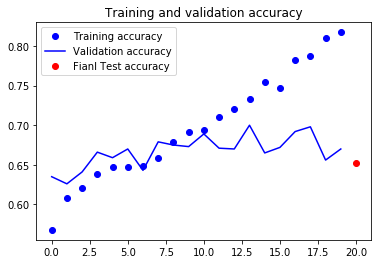

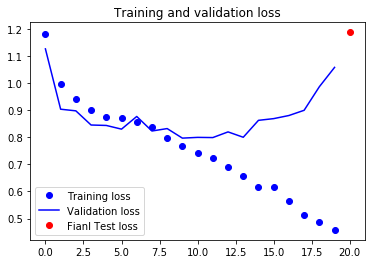

In [32]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = Complex_train.history['acc']
val_accuracy = Complex_train.history['val_acc']
loss = Complex_train.history['loss']
val_loss = Complex_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It seem that adding more layers to this model has done nothing but increase the run time. It does not seem to have done anything to decrease overfitting, or imporve accuracy.

# Attempt 5 (Smaller Convalution)

In [33]:
# Redefine Constents

batch_size = 64
epochs = 20
num_classes = 37

In [35]:
# Constructe the smallcon model

# First define the model as sequential.
smallcon_model = Sequential()
# Add a 2D convalutional layer
smallcon_model.add(Conv2D(32, kernel_size=(1, 1),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
smallcon_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
smallcon_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
smallcon_model.add(Dropout(0.25))
# Add a second convalutional layer, with 64 filters, rather then 32.
smallcon_model.add(Conv2D(64, (1, 1), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
smallcon_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
smallcon_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
smallcon_model.add(Dropout(0.25))
# Add a third 2D convolutional layer with 128 filters.
smallcon_model.add(Conv2D(128, (1, 1), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
smallcon_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
smallcon_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
smallcon_model.add(Dropout(0.4))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
smallcon_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
smallcon_model.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
smallcon_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
smallcon_model.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
smallcon_model.add(Dense(num_classes, activation='softmax'))

In [36]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
smallcon_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 106, 106, 32)      128       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 53, 53, 64)        2112      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 27, 27, 64)        0         
__________

In [37]:
# We now compile our Galaxy model.
smallcon_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [38]:
# Using this Galaxy model, with dropout layers, we will train our model. We will use 20 epochs.
smallcon_train = smallcon_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 207s 41ms/step - loss: 1.1955 - acc: 0.5676 - val_loss: 1.1618 - val_acc: 0.6150
Epoch 2/20
5000/5000 [==============================] - 208s 42ms/step - loss: 0.9797 - acc: 0.6076 - val_loss: 1.0785 - val_acc: 0.6440
Epoch 3/20
5000/5000 [==============================] - 188s 38ms/step - loss: 0.9528 - acc: 0.6166 - val_loss: 1.1197 - val_acc: 0.6600
Epoch 4/20
5000/5000 [==============================] - 173s 35ms/step - loss: 0.9172 - acc: 0.6310 - val_loss: 1.0904 - val_acc: 0.6550
Epoch 5/20
5000/5000 [==============================] - 171s 34ms/step - loss: 0.8905 - acc: 0.6424 - val_loss: 0.9670 - val_acc: 0.6560
Epoch 6/20
5000/5000 [==============================] - 165s 33ms/step - loss: 0.8600 - acc: 0.6516 - val_loss: 0.9269 - val_acc: 0.6660
Epoch 7/20
5000/5000 [==============================] - 147s 29ms/step - loss: 0.8383 - acc: 0.6622 - val_loss: 0.8771 - val_acc: 

In [39]:
# Comute the test accuracy and loss using our constructed model.
test_eval = smallcon_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 6s 6ms/step


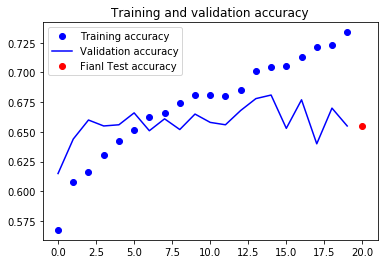

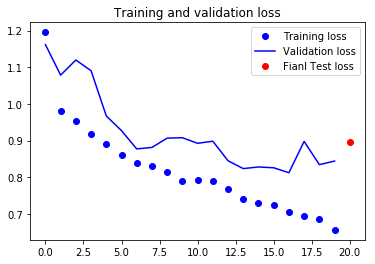

In [40]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = smallcon_train.history['acc']
val_accuracy = smallcon_train.history['val_acc']
loss = smallcon_train.history['loss']
val_loss = smallcon_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Of all the attempts I have made, this has been the most succesful at avoiding overfitting. However, it is unclear if this is becasue of an improvment in our model, or it is simply slower to evolve. The final test and validation accuracy and loss are about the same as in our other models.

# Attempt 6 (large convalution)

In [41]:
# Redefine Constents

batch_size = 64
epochs = 20
num_classes = 37

In [42]:
# Constructe the largecon model

# First define the model as sequential.
largecon_model = Sequential()
# Add a 2D convalutional layer
largecon_model.add(Conv2D(32, kernel_size=(5, 5),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
largecon_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
largecon_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
largecon_model.add(Dropout(0.25))
# Add a second convalutional layer, with 64 filters, rather then 32.
largecon_model.add(Conv2D(64, (5, 5), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
largecon_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
largecon_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
largecon_model.add(Dropout(0.25))
# Add a third 2D convolutional layer with 128 filters.
largecon_model.add(Conv2D(128, (5, 5), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
largecon_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
largecon_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
largecon_model.add(Dropout(0.4))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
largecon_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
largecon_model.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
largecon_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
largecon_model.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
largecon_model.add(Dense(num_classes, activation='softmax'))

In [43]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
largecon_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 106, 106, 32)      2432      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 53, 53, 64)        51264     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 27, 27, 64)        0         
__________

In [44]:
# We now compile our Galaxy model.
largecon_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [45]:
# Using this Galaxy model, with dropout layers, we will train our model. We will use 20 epochs.
largecon_train = largecon_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 604s 121ms/step - loss: 1.1437 - acc: 0.5756 - val_loss: 0.9422 - val_acc: 0.6230
Epoch 2/20
5000/5000 [==============================] - 579s 116ms/step - loss: 0.9987 - acc: 0.6012 - val_loss: 0.9205 - val_acc: 0.6420
Epoch 3/20
5000/5000 [==============================] - 583s 117ms/step - loss: 0.9399 - acc: 0.6182 - val_loss: 0.8878 - val_acc: 0.6170
Epoch 4/20
5000/5000 [==============================] - 580s 116ms/step - loss: 0.9044 - acc: 0.6274 - val_loss: 0.8503 - val_acc: 0.6600
Epoch 5/20
5000/5000 [==============================] - 591s 118ms/step - loss: 0.8731 - acc: 0.6416 - val_loss: 0.8222 - val_acc: 0.6690
Epoch 6/20
5000/5000 [==============================] - 577s 115ms/step - loss: 0.8267 - acc: 0.6556 - val_loss: 0.8040 - val_acc: 0.6770
Epoch 7/20
5000/5000 [==============================] - 590s 118ms/step - loss: 0.8097 - acc: 0.6644 - val_loss: 0.8155 - va

In [46]:
# Comute the test accuracy and loss using our constructed model.
test_eval = largecon_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 40s 40ms/step


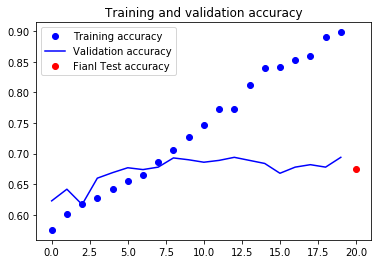

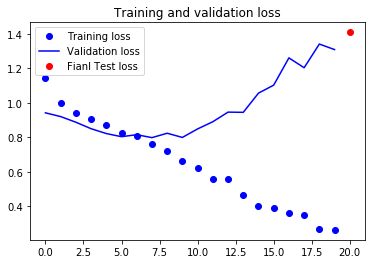

In [47]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = largecon_train.history['acc']
val_accuracy = largecon_train.history['val_acc']
loss = largecon_train.history['loss']
val_loss = largecon_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It does not seem that incressing the size of my convalutions in the convalution layer has helped to improve overfitting and accuracy either. 

# Attempt 7 (Even more dropout)

In [48]:
# Redefine Constents

batch_size = 64
epochs = 20
num_classes = 37

In [49]:
# Constructe the dropout2 model

# First define the model as sequential.
dropout2_model = Sequential()
# Add a 2D convalutional layer
dropout2_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
dropout2_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
dropout2_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 50% of inputs being dropped.
dropout2_model.add(Dropout(0.50))
# Add a second convalutional layer, with 64 filters, rather then 32.
dropout2_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
dropout2_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
dropout2_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 50% of inputs being dropped.
dropout2_model.add(Dropout(0.50))
# Add a third 2D convolutional layer with 128 filters.
dropout2_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
dropout2_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
dropout2_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 70% dropout
dropout2_model.add(Dropout(0.70))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
dropout2_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
dropout2_model.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
dropout2_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 55% dropout
dropout2_model.add(Dropout(0.55))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
dropout2_model.add(Dense(num_classes, activation='softmax'))

In [50]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
dropout2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 106, 106, 32)      896       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 53, 53, 64)        18496     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 27, 27, 64)        0         
__________

In [51]:
# We now compile our Galaxy model.
dropout2_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [52]:
# Using this Galaxy model, with dropout layers, we will train our model. We will use 20 epochs.
dropout2_train = dropout2_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 436s 87ms/step - loss: 1.2878 - acc: 0.5420 - val_loss: 1.0914 - val_acc: 0.6100
Epoch 2/20
5000/5000 [==============================] - 418s 84ms/step - loss: 1.0549 - acc: 0.5936 - val_loss: 0.9610 - val_acc: 0.6230
Epoch 3/20
5000/5000 [==============================] - 594s 119ms/step - loss: 0.9900 - acc: 0.6114 - val_loss: 0.9476 - val_acc: 0.6170
Epoch 4/20
5000/5000 [==============================] - 438s 88ms/step - loss: 0.9633 - acc: 0.6160 - val_loss: 0.9441 - val_acc: 0.6310
Epoch 5/20
5000/5000 [==============================] - 382s 76ms/step - loss: 0.9434 - acc: 0.6190 - val_loss: 0.9238 - val_acc: 0.6350
Epoch 6/20
5000/5000 [==============================] - 370s 74ms/step - loss: 0.9199 - acc: 0.6274 - val_loss: 0.8834 - val_acc: 0.6570
Epoch 7/20
5000/5000 [==============================] - 370s 74ms/step - loss: 0.9018 - acc: 0.6310 - val_loss: 0.8764 - val_acc:

In [53]:
# Comute the test accuracy and loss using our constructed model.
test_eval = dropout2_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 23s 23ms/step


In [55]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.8795581665039063
Test accuracy: 0.648


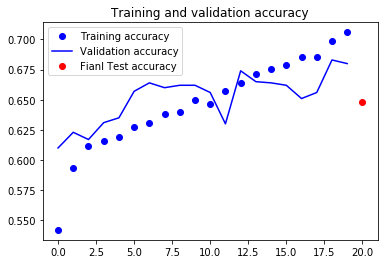

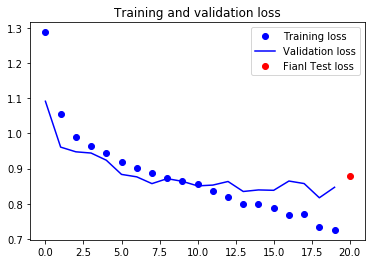

In [54]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = dropout2_train.history['acc']
val_accuracy = dropout2_train.history['val_acc']
loss = dropout2_train.history['loss']
val_loss = dropout2_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This trial seems to have less of an issue with overfitting, but it is still not very accurate. We also can see that the validation line startes to diverge in the last few samples.

# Attempt 8 (Starting with a higher batch size)

In [15]:
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

In [102]:
# Redefine Constents
batch_size = 64
epochs = 20
num_classes = 37

# First define the model as sequential.
long_model = Sequential()
# Add a 2D convalutional layer
long_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
long_model.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
long_model.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
long_model.add(Dropout(0.25))
# Add a second convalutional layer, with 64 filters, rather then 32.
long_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
long_model.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
long_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
long_model.add(Dropout(0.25))
# Add a third 2D convolutional layer with 128 filters.
long_model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
long_model.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
long_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
long_model.add(Dropout(0.4))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
long_model.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
long_model.add(Dense(256, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
long_model.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
long_model.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
long_model.add(Dense(num_classes, activation='softmax'))

In [103]:
# Again, we show the summary of the model we have constructed. Note the extra dropout layers. Also note that the total
# number of parameters is unchanged.
long_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 106, 106, 64)      1792      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 106, 106, 64)      0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 53, 53, 128)       73856     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 27, 27, 128)       0         
__________

In [104]:
long_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [105]:
long_model_train = long_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 1069s 214ms/step - loss: 1.1253 - acc: 0.5640 - val_loss: 0.9141 - val_acc: 0.6380
Epoch 2/20
5000/5000 [==============================] - 956s 191ms/step - loss: 0.9711 - acc: 0.6132 - val_loss: 0.9323 - val_acc: 0.6550
Epoch 3/20
5000/5000 [==============================] - 2939s 588ms/step - loss: 0.9216 - acc: 0.6200 - val_loss: 0.8983 - val_acc: 0.6570
Epoch 4/20
5000/5000 [==============================] - 1379s 276ms/step - loss: 0.8853 - acc: 0.6422 - val_loss: 0.8771 - val_acc: 0.6650
Epoch 5/20
5000/5000 [==============================] - 1743s 349ms/step - loss: 0.8494 - acc: 0.6518 - val_loss: 0.8526 - val_acc: 0.6620
Epoch 6/20
5000/5000 [==============================] - 2310s 462ms/step - loss: 0.8132 - acc: 0.6676 - val_loss: 0.8503 - val_acc: 0.6590
Epoch 7/20
5000/5000 [==============================] - 7791s 2s/step - loss: 0.7845 - acc: 0.6880 - val_loss: 0.8683 -

In [106]:
# Comute the test accuracy and loss using our constructed model.
test_eval = long_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 48s 48ms/step


In [107]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 2.116602544784546
Test accuracy: 0.662


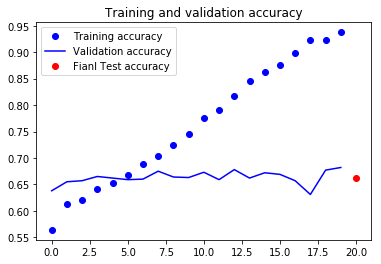

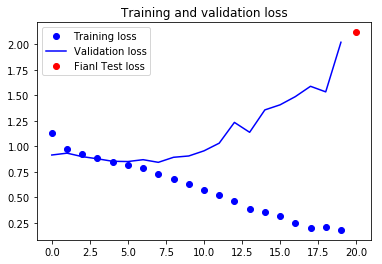

In [108]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = long_model_train.history['acc']
val_accuracy = long_model_train.history['val_acc']
loss = long_model_train.history['loss']
val_loss = long_model_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This model was an unmidigated flop. We see that the validation loss function plumites after just a few epochs, and the validation accuracy remains almost constent. This is a sign of drastic overfitting.

# Attempt 9 (Convalution Blocks)

In [15]:
# Redefine Constents
batch_size = 64
epochs = 20
num_classes = 37

# Add first Block
block_model = Sequential()
block_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(106,106,3)))
block_model.add(Conv2D(32, (3, 3), activation='relu'))
block_model.add(MaxPooling2D(pool_size=(2, 2)))
block_model.add(Dropout(0.25))

# Add second Block
block_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
block_model.add(Conv2D(64, (3, 3), activation='relu'))
block_model.add(MaxPooling2D(pool_size=(2, 2)))
block_model.add(Dropout(0.25))

# Add third Block
block_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
block_model.add(Conv2D(64, (3, 3), activation='relu'))
block_model.add(MaxPooling2D(pool_size=(2, 2)))
block_model.add(Dropout(0.25))

# Flatten model
block_model.add(Flatten())

# Add fully conected Block
block_model.add(Dense(512, activation='relu'))
block_model.add(Dropout(0.5))

# Create Output Layer
block_model.add(Dense(num_classes, activation='softmax'))

In [16]:
block_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 106, 106, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [17]:
block_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [18]:
block_model_train = block_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 806s 161ms/step - loss: 1.2319 - acc: 0.5560 - val_loss: 1.0578 - val_acc: 0.6100
Epoch 2/20
5000/5000 [==============================] - 843s 169ms/step - loss: 1.0122 - acc: 0.6020 - val_loss: 0.9920 - val_acc: 0.6100
Epoch 3/20
5000/5000 [==============================] - 879s 176ms/step - loss: 1.0047 - acc: 0.5944 - val_loss: 0.9111 - val_acc: 0.6240
Epoch 4/20
5000/5000 [==============================] - 1002s 200ms/step - loss: 0.9595 - acc: 0.6050 - val_loss: 0.8988 - val_acc: 0.6310
Epoch 5/20
5000/5000 [==============================] - 861s 172ms/step - loss: 0.9544 - acc: 0.6024 - val_loss: 0.9023 - val_acc: 0.6290
Epoch 6/20
5000/5000 [==============================] - 858s 172ms/step - loss: 0.9350 - acc: 0.6166 - val_loss: 0.9256 - val_acc: 0.6450
Epoch 7/20
5000/5000 [==============================] - 1010s 202ms/step - loss: 0.9315 - acc: 0.6204 - val_loss: 0.9039 - 

In [19]:
# Comute the test accuracy and loss using our constructed model.
test_eval = block_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 49s 49ms/step


In [20]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9213302688598632
Test accuracy: 0.628


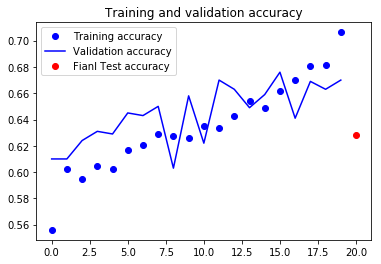

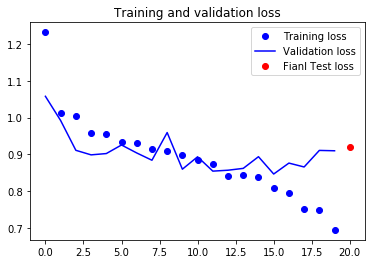

In [21]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = block_model_train.history['acc']
val_accuracy = block_model_train.history['val_acc']
loss = block_model_train.history['loss']
val_loss = block_model_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training Accuracy

In [26]:
# Let us look at the individual precisions in our models training data.

Y_test = np.argmax(training_labels, axis=1) # Convert one-hot to index
y_pred = block_model.predict_classes(training_imgs) # Use predict_classes to make pridictions
print(classification_report(Y_test, y_pred)) # Print our data

             precision    recall  f1-score   support

          0       0.87      0.29      0.43       455
          1       0.73      0.72      0.73      1265
          2       1.00      1.00      1.00         1
         13       0.88      0.45      0.60       283
         14       0.77      0.89      0.83      2996

avg / total       0.78      0.77      0.75      5000



### Validation Accuracy

In [27]:
# Let us look at the individual precisions in our models validation data.

Y_val = np.argmax(validation_labels, axis=1) # Convert one-hot to index
y_pred = block_model.predict_classes(validation_imgs) # Use predict_classes to make pridictions
print(classification_report(Y_val, y_pred)) # Print our data

             precision    recall  f1-score   support

          0       0.38      0.06      0.11        80
          1       0.57      0.60      0.59       253
          2       0.00      0.00      0.00         1
         13       0.26      0.09      0.13        56
         14       0.72      0.83      0.77       610

avg / total       0.63      0.67      0.64      1000



//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Test Accuracy

In [22]:
# Let us look at the individual precisions in our models test data.

Y_test = np.argmax(test_labels, axis=1) # Convert one-hot to index
y_pred = block_model.predict_classes(test_imgs) # Use predict_classes to make pridictions
print(classification_report(Y_test, y_pred)) # Print our data

             precision    recall  f1-score   support

          0       0.20      0.05      0.08        94
          1       0.52      0.50      0.51       244
         13       0.26      0.12      0.16        50
         14       0.69      0.81      0.74       612

avg / total       0.58      0.63      0.60      1000



After so many attempts at modeling this data, it is interesting to see where some of the limitations might be. It is particularly interesting to see that the test data only contains four viable solutions, and further that only one of those solutions holds over half of the total data. It is therefor not suprising to see that it is by far the most accurate. We compair this to the training and validation accuracy and see that they also have very few catagories, in this case one more then the test data.

This model was taken from an example of a keras model I found online. It seems to have worked better then many of the models I have run up to this point, with only small indications of overfitting near the end of this model. However, there still seems to be a disparity between training accuracy and test accuracy. Also, this model has been very slow to evolve, resulting in the final accuracy being not much better then many of my earlyer models.

# Attempt 10 (Trying to get rid of extra catagories)

In [40]:
# Redefine Constents
batch_size = 64
epochs = 20
num_classes = 5

# Add first Block
block_model2 = Sequential()
block_model2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(106,106,3)))
block_model2.add(Conv2D(32, (3, 3), activation='relu'))
block_model2.add(MaxPooling2D(pool_size=(2, 2)))
block_model2.add(Dropout(0.25))

# Add second Block
block_model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
block_model2.add(Conv2D(64, (3, 3), activation='relu'))
block_model2.add(MaxPooling2D(pool_size=(2, 2)))
block_model2.add(Dropout(0.25))

# Add third Block
block_model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
block_model2.add(Conv2D(64, (3, 3), activation='relu'))
block_model2.add(MaxPooling2D(pool_size=(2, 2)))
block_model2.add(Dropout(0.25))

# Flatten model
block_model2.add(Flatten())

# Add fully conected Block
block_model2.add(Dense(512, activation='relu'))
block_model2.add(Dropout(0.5))

# Create Output Layer
block_model2.add(Dense(num_classes, activation='softmax'))

In [41]:
block_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 106, 106, 32)      896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 104, 104, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)        0         
__________

In [42]:
block_model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [99]:
# Convert training data to 5 catagory output
Y_training = np.argmax(training_labels, axis=1) # Convert one-hot to index

Y_training[Y_training == 13] = 3
Y_training[Y_training == 14] = 4

training_labels = to_categorical(Y_training)

# Convert validation data to 5 catagory output
Y_val = np.argmax(validation_labels, axis=1) # Convert one-hot to index

Y_val[Y_val == 13] = 3
Y_val[Y_val == 14] = 4

validation_labels = to_categorical(Y_val)

# Convert validation data to 5 catagory output
Y_test = np.argmax(test_labels, axis=1) # Convert one-hot to index

Y_test[Y_test == 13] = 3
Y_test[Y_test == 14] = 4

test_labels = to_categorical(Y_test)

In [44]:
block_model_train = block_model2.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 822s 164ms/step - loss: 1.0945 - acc: 0.5674 - val_loss: 0.9624 - val_acc: 0.6100
Epoch 2/20
5000/5000 [==============================] - 637s 127ms/step - loss: 1.0068 - acc: 0.6002 - val_loss: 0.9643 - val_acc: 0.6080
Epoch 3/20
5000/5000 [==============================] - 639s 128ms/step - loss: 0.9738 - acc: 0.5940 - val_loss: 0.9517 - val_acc: 0.6180
Epoch 4/20
5000/5000 [==============================] - 619s 124ms/step - loss: 0.9556 - acc: 0.6010 - val_loss: 0.9820 - val_acc: 0.6120
Epoch 5/20
5000/5000 [==============================] - 626s 125ms/step - loss: 0.9480 - acc: 0.6142 - val_loss: 0.9000 - val_acc: 0.6440
Epoch 6/20
5000/5000 [==============================] - 631s 126ms/step - loss: 0.9223 - acc: 0.6202 - val_loss: 0.8791 - val_acc: 0.6460
Epoch 7/20
5000/5000 [==============================] - 630s 126ms/step - loss: 0.9190 - acc: 0.6282 - val_loss: 0.9148 - va

In [45]:
# Comute the test accuracy and loss using our constructed model.
test_eval = block_model2.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 44s 44ms/step


In [46]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1378603191375734
Test accuracy: 0.643


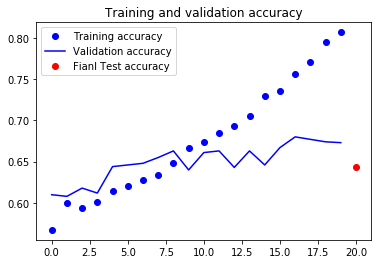

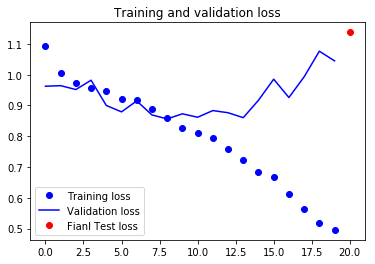

In [47]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = block_model_train.history['acc']
val_accuracy = block_model_train.history['val_acc']
loss = block_model_train.history['loss']
val_loss = block_model_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [55]:
print('Catagorical Test Accuracy')

# Let us look at the individual precisions in our models test data.

Y_test = np.argmax(test_labels, axis=1) # Convert one-hot to index
y_pred = block_model2.predict_classes(test_imgs) # Use predict_classes to make pridictions
target_names = ['Class 1.1','Class 1.2','Class 6.1','Class 6.2']
print(classification_report(Y_test, y_pred, target_names=target_names)) # Print our data

Catagorical Test Accuracy
             precision    recall  f1-score   support

  Class 1.1       0.29      0.04      0.07        94
  Class 1.2       0.53      0.44      0.48       244
  Class 6.1       0.44      0.14      0.21        50
  Class 6.2       0.68      0.86      0.76       612

avg / total       0.60      0.64      0.60      1000



In this attempt, I tried taking out all of the extrainius catagories that are avalible for galexies to be placed into, but are not selected in any of the files seen in our data set. This does not seem to have made any great impact. While the model was able to train much faster then the other block model I constructed, which was exactly the same but had 37 catagories, it seems to have the same problems with overfitting as any of my other models.

# Attempt 11 (Original model with less catagories)

In [100]:
# Redefine Constents
batch_size = 64
epochs = 20
num_classes = 5

# Constructe the Galaxy model. 

# First define the model as sequential.
Galaxy_model2 = Sequential()
# Add a 2D convalutional layer
# input: 106x106 images with 3 channels -> (106, 106, 3) tensors.
Galaxy_model2.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(106,106,3)))
# Add a Leaky version of a Rectified Linear Unit
Galaxy_model2.add(LeakyReLU(alpha=0.1))
# Add a 2D pooling layer to avoid overfitting
Galaxy_model2.add(MaxPooling2D((2, 2),padding='same'))
# Add first dropout layer with 25% of inputs being dropped.
Galaxy_model2.add(Dropout(0.25))
# Add a second convalutional layer, with 64 filters, rather then 32.
Galaxy_model2.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Galaxy_model2.add(LeakyReLU(alpha=0.1))
# Add a Max pooling operation
Galaxy_model2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add second dropout layer with 25% of inputs being dropped.
Galaxy_model2.add(Dropout(0.25))
# Add a third 2D convolutional layer with 128 filters.
Galaxy_model2.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# Add another Leaky version of a Rectified Linear Unit
Galaxy_model2.add(LeakyReLU(alpha=0.1)) 
# Add another max pooling operation
Galaxy_model2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# Add third dropout layer with 40% dropout
Galaxy_model2.add(Dropout(0.4))
# Flatten the input layer (our data after this last max pooling layer) for use in the next layer
Galaxy_model2.add(Flatten())
# Add a normal fully conected neural network layer with 128 units
Galaxy_model2.add(Dense(128, activation='linear'))
# Add another Leaky version of a Rectified Linear Unit
Galaxy_model2.add(LeakyReLU(alpha=0.1))     
# Add fourth dropout layer with 30% dropout
Galaxy_model2.add(Dropout(0.3))
# Add our output layer with our number of classes. This will also be a normal fully conected layer.
Galaxy_model2.add(Dense(num_classes, activation='softmax'))

In [101]:
Galaxy_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 106, 106, 32)      896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 106, 106, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 53, 53, 64)        18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 27, 27, 64)        0         
__________

In [102]:
Galaxy_model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [103]:
Galaxy_model2_train = Galaxy_model2.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 510s 102ms/step - loss: 1.0404 - acc: 0.5944 - val_loss: 0.9139 - val_acc: 0.6250
Epoch 2/20
5000/5000 [==============================] - 483s 97ms/step - loss: 0.9513 - acc: 0.6176 - val_loss: 0.8747 - val_acc: 0.6450
Epoch 3/20
5000/5000 [==============================] - 369s 74ms/step - loss: 0.9187 - acc: 0.6284 - val_loss: 0.8815 - val_acc: 0.6670
Epoch 4/20
5000/5000 [==============================] - 326s 65ms/step - loss: 0.8784 - acc: 0.6422 - val_loss: 0.8448 - val_acc: 0.6410
Epoch 5/20
5000/5000 [==============================] - 343s 69ms/step - loss: 0.8445 - acc: 0.6566 - val_loss: 0.8288 - val_acc: 0.6780
Epoch 6/20
5000/5000 [==============================] - 371s 74ms/step - loss: 0.8214 - acc: 0.6712 - val_loss: 0.8313 - val_acc: 0.6620
Epoch 7/20
5000/5000 [==============================] - 484s 97ms/step - loss: 0.7773 - acc: 0.6870 - val_loss: 0.8155 - val_acc:

In [104]:
# Comute the test accuracy and loss using our constructed model.
test_eval = Galaxy_model2.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 33s 33ms/step


In [105]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.5945631017684936
Test accuracy: 0.637


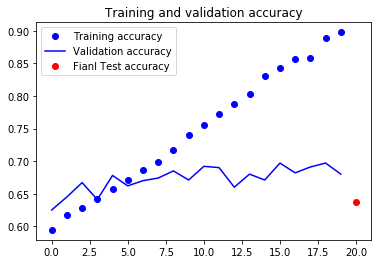

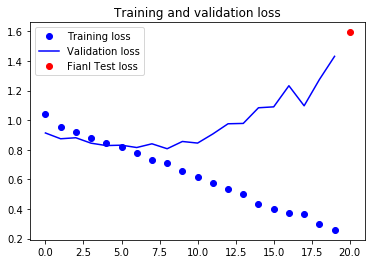

In [106]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = Galaxy_model2_train.history['acc']
val_accuracy = Galaxy_model2_train.history['val_acc']
loss = Galaxy_model2_train.history['loss']
val_loss = Galaxy_model2_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(20, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(20, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [107]:
print('Catagorical Test Accuracy')

# Let us look at the individual precisions in our models test data.

Y_test = np.argmax(test_labels, axis=1) # Convert one-hot to index
y_pred = Galaxy_model2.predict_classes(test_imgs) # Use predict_classes to make pridictions
target_names = ['Class 1.1','Class 1.2','Class 6.1','Class 6.2']
print(classification_report(Y_test, y_pred, target_names=target_names)) # Print our data

Catagorical Test Accuracy
             precision    recall  f1-score   support

  Class 1.1       0.31      0.17      0.22        94
  Class 1.2       0.56      0.35      0.43       244
  Class 6.1       0.36      0.18      0.24        50
  Class 6.2       0.68      0.86      0.76       612

avg / total       0.60      0.64      0.60      1000



This model also does not seem to have solved the issues I have found with overfitting. In fact, it seems to be about the same as my first model of this type. I still think it was worth looking into how removing the extronious classes from the model would effect the fit, but it seems that it has not had the desiered effect. 

# Attempt 12

In [111]:
# Redefine Constents
batch_size = 64
epochs = 100
num_classes = 5

from keras.layers import Activation

last_model = Sequential()
last_model.add(Conv2D(32, (3, 3), input_shape=(106, 106, 3)))
last_model.add(Activation('relu'))
last_model.add(Dropout(0.60))
last_model.add(MaxPooling2D(pool_size=(2, 2)))

last_model.add(Conv2D(32, (3, 3)))
last_model.add(Activation('relu'))
last_model.add(Dropout(0.60))
last_model.add(MaxPooling2D(pool_size=(2, 2)))

last_model.add(Conv2D(64, (3, 3)))
last_model.add(Activation('relu'))
last_model.add(Dropout(0.80))
last_model.add(MaxPooling2D(pool_size=(2, 2)))

last_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
last_model.add(Dense(64))
last_model.add(Activation('relu'))
last_model.add(Dropout(0.60))
last_model.add(Dense(num_classes))
last_model.add(Activation('sigmoid'))


In [112]:
last_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 104, 104, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 104, 104, 32)      0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 104, 104, 32)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 50, 50, 32)        0         
__________

In [113]:
last_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [114]:
last_model_train = last_model.fit(training_imgs, training_labels, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_imgs, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 283s 57ms/step - loss: 1.1329 - acc: 0.5864 - val_loss: 1.2925 - val_acc: 0.6100
Epoch 2/100
5000/5000 [==============================] - 202s 40ms/step - loss: 1.0382 - acc: 0.5952 - val_loss: 1.2840 - val_acc: 0.6100
Epoch 3/100
5000/5000 [==============================] - 229s 46ms/step - loss: 1.0161 - acc: 0.5948 - val_loss: 1.2081 - val_acc: 0.6100
Epoch 4/100
5000/5000 [==============================] - 181s 36ms/step - loss: 0.9760 - acc: 0.5994 - val_loss: 1.1829 - val_acc: 0.6100
Epoch 5/100
5000/5000 [==============================] - 161s 32ms/step - loss: 0.9515 - acc: 0.5990 - val_loss: 1.1716 - val_acc: 0.6100
Epoch 6/100
5000/5000 [==============================] - 180s 36ms/step - loss: 0.9523 - acc: 0.6002 - val_loss: 1.1445 - val_acc: 0.6100
Epoch 7/100
5000/5000 [==============================] - 163s 33ms/step - loss: 0.9340 - acc: 0.6008 - val_loss: 1.1164 - va

In [115]:
test_eval = last_model.evaluate(test_imgs, test_labels, verbose=1)

1000/1000 [==============================] - 28s 28ms/step


In [116]:
# Print the accuracy and loss of the test data.
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9219609260559082
Test accuracy: 0.63


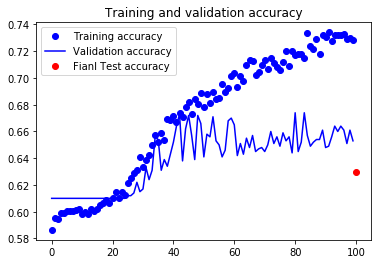

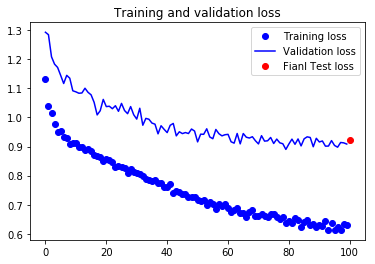

In [119]:
# We will once again plot the accurany and loss of our model as a function of epoch.

# Collect accuracy and loss data from the training and validation data colected after each epoch in our model.
accuracy = last_model_train.history['acc']
val_accuracy = last_model_train.history['val_acc']
loss = last_model_train.history['loss']
val_loss = last_model_train.history['val_loss']

# Define a list ranging from 1 to 20 for the epochs variable.
epochs = range(len(accuracy))
# Plot the accuracy of the training data as a funciton of the epoch number.
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
# Plot the accuracy of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
# Plot the accuracy of the test data at epoch 20.
plt.plot(100, test_eval[1], 'ro', label='Fianl Test accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot the loss of the training data as a funciton of the epoch number.
plt.plot(epochs, loss, 'bo', label='Training loss')
# Plot the loss of the validation data as a funciton of the epoch number.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Plot the loss of the test data at epoch 20.
plt.plot(100, test_eval[0], 'ro', label='Fianl Test loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [118]:
print('Catagorical Test Accuracy')

# Let us look at the individual precisions in our models test data.

Y_test = np.argmax(test_labels, axis=1) # Convert one-hot to index
y_pred = last_model.predict_classes(test_imgs) # Use predict_classes to make pridictions
target_names = ['Class 1.1','Class 1.2','Class 6.1','Class 6.2']
print(classification_report(Y_test, y_pred, target_names=target_names)) # Print our data

Catagorical Test Accuracy
             precision    recall  f1-score   support

  Class 1.1       0.00      0.00      0.00        94
  Class 1.2       0.69      0.12      0.20       244
  Class 6.1       0.00      0.00      0.00        50
  Class 6.2       0.63      0.98      0.77       612

avg / total       0.55      0.63      0.52      1000



//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In this model I wanted to see the effect of having a rediculesly large dropout over a large number of epochs. While this model seems to have avoided overfitting for longer then most, it still peaked in accuracy at about 65% in the validation data. I am begining to wonder if there is some sort of limit to our data here. Also, when looking at the catagorical test accuracy, we see that both class 1.1 and 6.1 have zero precision. This is a distinced sign of overfitting.

After performing twelve of these models, it is clear that I have not yet found a method of analising this data to find a robust model. With only one exeption, all of these models have been overfit, and the one that wasn't showed sighs that it would start to seperate shortly. None of these models broke 70% accuracy in the test data, and I think the reason for that is clear. Unlike the data sets we looked at previously, this set had wildly different numbers of entires in each catagory. While many of my models were able to predict the two largest groups with decent accuracy, the two smaller groups were almost always modeled incorectly. While I think some of these models might be usable in determining if a galexy belongs in class 1.2 or 6.2, it is overall not reliable enough to set to this task.